Preproces data for computing pca during test period

trial_error:
* 0: correct trial
* 6: false alarm (relase during test period)
* 8: missed target

In [1]:
# Pipeline for preprocessing data for pca analysis
from preproc_tools import get_neuron_sample_test_fr, to_python_hdf5
import glob
import os
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
import json
from pathlib import Path
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ephysvibe.trials import align_trials, select_trials
from ephysvibe.structures.neuron_data import NeuronData

In [2]:
def z_score(X,with_std=False):
    # X: ndarray, shape (n_features, n_samples)
    # X=X/ np.max(X,axis=1).reshape(-1,1)
    ss = StandardScaler(with_mean=True, with_std=with_std)
    Xz = ss.fit_transform(X.T).T
    return Xz,ss

In [3]:
def compute_pca(x, n_comp=50):
    model = PCA(n_components=n_comp)
    # C = model.components_
    # pc_s = C @ x
    pc_s = model.fit_transform(x.T).T
    return model, pc_s

In [4]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [5]:
# Define parameters
filepaths = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/"
outputpath = "./test/"

area = "lip"
subject = "Riesling"
avgwin = 100
min_sp_sec = 5
n_test = 1
min_trials = 10
nonmatch = True  # if True: includes nonmatch trials

# sample timing
time_before_sample = 500
start_sample = -200
end_sample = 450 + 400

# test timing
time_before_test = 500
start_test = -400
end_test = n_test * 450 + 200
# -------------------------------------------- End parameters ------------------------------------------

# Compute idxs
idx_start_sample = time_before_sample + start_sample
idx_end_sample = time_before_sample + end_sample
idx_start_test = time_before_test + start_test
idx_end_test = time_before_test + end_test
# total trial duration
trial_dur = end_sample - start_sample + end_test - start_test


In [6]:
# ------------------------------------------ Start preprocessing ----------------------------------------
neu_path = filepaths + "*neu.h5"
path_list = glob.glob(neu_path)


In [ ]:
def get_neuron_sample_test_fr(
    path,
    time_before_sample,
    time_before_test,
    idx_start_sample,
    idx_end_sample,
    idx_start_test,
    idx_end_test,
    n_test,
    min_trials,
    nonmatch=True,
    avgwin=50,
    n_sp_sec=5,
):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block = 1
    code = 1
    # Select trials aligned to sample onset
    sp_sample_on, sp_test_on, mask_s, mask_t = select_sample_test_aligned_trials(
        neu_data, select_block, code, time_before_sample, time_before_test, error_type=0
    )
    # Build masks to select trials with match in the n_test
    mask_match = np.where(
        neu_data.test_stimuli[mask_t, n_test - 1] == neu_data.sample_id[mask_t],
        True,
        False,
    )
    mask_neu = neu_data.sample_id[mask_t] == 0
    # Build masks to select trials with the selected number of test presentations
    max_test = neu_data.test_stimuli[mask_t].shape[1]
    mask_ntest = (
        max_test - np.sum(np.isnan(neu_data.test_stimuli[mask_t]), axis=1)
    ) > (n_test - 1)

    if nonmatch:  # include nonmatch trials
        mask_match_neu = np.logical_or(mask_ntest, mask_neu)
    else:
        mask_match_neu = np.logical_or(mask_match, mask_neu)
    if np.sum(mask_match_neu) < 20:
        return {"fr": None}

    # Average fr across time
    avg_sample_on = firing_rate.moving_average(
        sp_sample_on[mask_match_neu], win=avgwin, step=1
    )[:, idx_start_sample:idx_end_sample]
    avg_test1_on = firing_rate.moving_average(
        sp_test_on[mask_match_neu], win=avgwin, step=1
    )[:, idx_start_test:idx_end_test]
    # Concatenate sample and test aligned data
    sp = np.concatenate((avg_sample_on, avg_test1_on), axis=1)
    # Check fr
    ms_fr = np.nanmean(sp) * 1000 > n_sp_sec
    if not ms_fr:
        return {"fr": None}
    # Check number of trials
    sample_id = neu_data.sample_id[mask_t][mask_match_neu]
    samples = [0, 11, 15, 55, 51]
    for s_id in samples:
        sample_fr = sp[np.where(sample_id == s_id, True, False)]
        if sample_fr.shape[0] < min_trials:
            return {"fr": None}
    # Get trials grouped by sample
    fr_samples = select_trials.get_sp_by_sample(sp, sample_id, samples=samples)

    if fr_samples is None:
        return {"fr": None}
    return {"fr": fr_samples}


In [32]:
data = Parallel(n_jobs=-1)(
    delayed(get_neuron_sample_test_fr)(
        path=path,
        time_before_sample=time_before_sample,
        time_before_test=time_before_test,
        idx_start_sample=idx_start_sample,
        idx_end_sample=idx_end_sample,
        idx_start_test=idx_start_test,
        idx_end_test=idx_end_test,
        n_test=n_test,
        min_trials=min_trials,
        nonmatch=nonmatch,
        avgwin=avgwin,
        n_sp_sec=min_sp_sec,
    )
    for path in tqdm(path_list)
)

100%|██████████| 530/530 [11:47<00:00,  1.33s/it]


In [81]:
path_list[130]

'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/2022-12-01_12-01-59_Riesling_lip_e1_r1_good3_neu.h5'

In [ ]:
2023-02-08_10-39-41

In [88]:
neu_data = NeuronData.from_python_hdf5('/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/2023-03-16_10-20-01_Riesling_lip_e1_r1_good1_neu.h5')

Try to detect errors and categorize trials in H,FA,M

In [83]:
bar_release = 4

In [94]:
bhvcode = np.full(len(neu_data.block),np.nan)
test_bhv = np.full(neu_data.test_stimuli.shape,np.nan)

maskb1 = neu_data.block==1
#Mask to select trials were the error code was 0,6 or 8 
trial_error = neu_data.trial_error
maskerror = np.logical_or(trial_error==0,np.logical_or(trial_error==6,trial_error==8)) 
maskb1error = np.logical_and(maskb1,maskerror)

#trial_error=trial_error[maskb1error]
sample_id=neu_data.sample_id#[maskb1error]
test_stimuli=neu_data.test_stimuli#[maskb1error]
code_numbers=neu_data.code_numbers#[maskb1error]

# 1 Check trials in which sample was presented turing the test period
match_loc = sample_id.reshape(-1,1)==test_stimuli
# 1A. Check if sample was presented more than once
mask_rep_sample = np.logical_and(maskb1error, (np.sum(match_loc,axis=1)>1))
if np.sum(mask_rep_sample) > 0:
    ## error in the task code -> We have a 3312!!
    bhvcode[mask_rep_sample]=3312 # There is one miss and one hit
    #TODO Add the code for and H to test_bhv 
# 1B. When sample was presented once, check if it was hit or miss
# Mark as hit trials with matching sample and test
mask_one_sample = np.logical_and(maskb1error, np.sum(match_loc,axis=1)==1)
if np.sum(mask_one_sample) > 0:
    # Assume all hits
    bhvcode[mask_one_sample] = 0 
    # Check if any miss (sample presented but no bar release)
    hit_or_miss = np.where(code_numbers == bar_release,False,True)
    hit_or_miss = np.all(hit_or_miss,axis=1)
    bhvcode[np.logical_and(mask_one_sample,hit_or_miss)]=8
    #TODO add code for hit or miss to test_bhv
# 2 Check trials in which sample was NOT presented during the test period 
nonmatch_loc = sample_id.reshape(-1,1)!=test_stimuli
nonmatch_tr=np.all(nonmatch_loc,axis=1)
# TODO Select trials with at least one test presentation (if errors are 0,6 or 8 should be always the case)
# 2A. Asume all correct trials (catch or neutral case)
bhvcode[np.logical_and(maskb1error,nonmatch_tr)]=0
# 2B. If sample not presented but the subject relesed bar -> FA(6) 
# Check if monkey released the bar
false_alarm = np.where(code_numbers == bar_release,True,False)
false_alarm = np.any(false_alarm,axis=1)
fa_mask = np.logical_and(maskb1error,np.logical_and(nonmatch_tr,false_alarm))
bhvcode[fa_mask] = 6
#TODO add code for fa to test_bhv


In [97]:
align_on=3
time_before_sample=0
sp_out_on,mask_out  =   align_trials.align_on(
        sp_samples  =   neu_data.sp_samples,
        code_samples=   neu_data.code_samples,
        code_numbers=   neu_data.code_numbers,
        trial_error =   neu_data.trial_error,
        block       =   neu_data.block,
        pos_code    =   neu_data.pos_code,
        select_block =   1,
        select_pos  =   -1,
        event       =   'test_on_' + str(align_on+1),
        time_before =   time_before_sample,
        error_type  =   0,
    )
match = np.where(neu_data.sample_id[mask_out]==neu_data.test_stimuli[mask_out, align_on])[0]
n_errors = np.sum(np.sum(np.isnan(neu_data.test_stimuli[mask_out][match])==False,axis=1)!=align_on+1)
n_errors

2

In [99]:
neu_data.sample_id[mask_out][match]

array([51., 51., 55., 11., 55., 51., 55., 11., 55., 11., 55., 11., 11.,
       51., 51., 11., 15., 55., 11., 15., 55., 55., 51., 15., 55.])

In [98]:
neu_data.test_stimuli[mask_out][match]

array([[55., 43., 24., 51., 81.],
       [31., 12., 88., 51., nan],
       [15., 47., 85., 55., nan],
       [58., 21., 15., 11., nan],
       [15., 57., 15., 55., nan],
       [13., 27., 61., 51., nan],
       [11., 56., 65., 55., nan],
       [55., 71., 15., 11., nan],
       [17., 45., 27., 55., nan],
       [51., 71., 12., 11., nan],
       [65., 58., 87., 55., nan],
       [41., 55., 21., 11., nan],
       [51., 18., 71., 11., nan],
       [15., 41., 54., 51., nan],
       [11., 82., 57., 51., nan],
       [31., 88., 21., 11., nan],
       [13., 55., 14., 15., nan],
       [53., 75., 57., 55., nan],
       [21., 13., 87., 11., nan],
       [11., 35., 11., 15., nan],
       [57., 28., 11., 55., nan],
       [11., 85., 73., 55., nan],
       [56., 61., 33., 51., 58.],
       [65., 44., 85., 15., nan],
       [35., 47., 75., 55., nan]])

0
-2
2


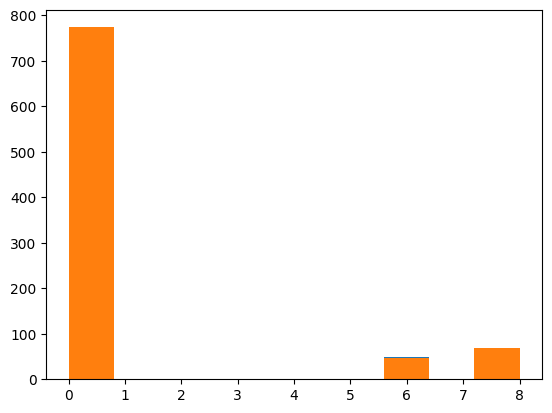

In [92]:
plt.hist(trial_error[maskb1error])
plt.hist(bhvcode)
for i in [0,6,8]:
    print(np.sum(bhvcode==i)-np.sum(trial_error[maskb1error]==i))

In [107]:
np.where(bhvcode[maskb1error]!=trial_error[maskb1error])[0]

array([ 12, 148, 216, 815])

In [112]:
trial_error[maskb1error][np.where(bhvcode[maskb1error]!=trial_error[maskb1error])[0]]

array([0., 6., 6., 0.])

In [111]:
bhvcode[maskb1error][np.where(bhvcode[maskb1error]!=trial_error[maskb1error])[0]]

array([8., 0., 0., 8.])

In [109]:
neu_data.test_stimuli[maskb1error][np.where(bhvcode[maskb1error]!=trial_error[maskb1error])[0]]

array([[55., 43., 24., 51., 81.],
       [83., 18., 81., 15., nan],
       [23., 15., 28., 55., nan],
       [56., 61., 33., 51., 58.]])

In [110]:
neu_data.sample_id[maskb1error][np.where(bhvcode[maskb1error]!=trial_error[maskb1error])[0]]

array([51., 15., 55., 51.])

(array([774.,   0.,   0.,   0.,   0.,   0.,   0.,  46.,   0.,  68.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

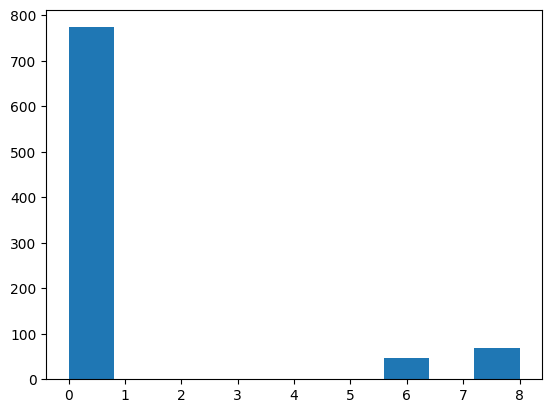

In [106]:
plt.hist(bhvcode)

End--------------

In [23]:
select_block = 1
code=1
# * 0: correct trial (Hits and Correct rejections)
error_type = 0
# Select trials aligned to sample onset
HCRsp_test_on, HCRmask_t = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block=select_block,
    select_pos=code,
    event="test_on_1",
    time_before=time_before_test,
    error_type=error_type,
)
# * 8: missed target
error_type = 8
# Select trials aligned to sample onset
Msp_test_on, Mmask_t = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block=select_block,
    select_pos=code,
    event="test_on_1",
    time_before=time_before_test,
    error_type=error_type,
)

In [ ]:
# * 6: false alarm (relase during test period)
error_type = 6
before_test = 400
after_test = 400
ntest=neu_data.test_stimuli.shape[1]
ntr = np.logical_and(neu_data.trial_error==error_type,neu_data.block==select_block)
FA_tr_tt = np.full((ntr,ntest,before_test+after_test+460),np.nan)

# Select trials aligned to sample onset
FAsp_test_on, FAmask_t = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block=select_block,
    select_pos=code,
    event="test_on_1",
    time_before=time_before_test,
    error_type=error_type,
)

In [62]:
# FA: bar release before matching test stim presentation
bar_release = 4
test_on_1= 25
test_on_2= 27
sample_on = 23
test_stimuli=neu_data.test_stimuli[FAmask_t]
sample_id=neu_data.sample_id[FAmask_t]
code_samples=neu_data.code_samples[FAmask_t]
code_numbers = neu_data.code_numbers[FAmask_t]
FA_moment = (code_samples[code_numbers==bar_release]-code_samples[code_numbers==test_on_1])
FA_in_test = np.floor(FA_moment/459)
FA_in_test



array([0., 1., 0., 1., 1., 0., 3., 2., 2., 4., 2., 2., 1., 4., 0., 2., 0.,
       1., 1., 3., 4., 0., 2., 1., 0., 1.])

In [64]:
code_samples[np.any(code_numbers==test_on_2,axis=1)][code_numbers[np.any(code_numbers==test_on_2,axis=1)]==test_on_1]-code_samples[code_numbers==test_on_2]

array([-459., -459., -459., -459., -459., -459., -459., -459., -459.,
       -459., -459., -459., -459., -459., -460., -460., -459., -459.,
       -460.])

In [ ]:
sel_idx = np

In [28]:
FAsp_test_on[]

array([5., 0., 0., ..., 3., 4., 4.])

array([1., 2., 1., 2., 2., 1., 4., 3., 3., 5., 3., 3., 2., 5., 1., 3., 1.,
       2., 2., 4., 5., 1., 3., 2., 1., 2.])

In [22]:
# trial_error:



H = 
CR = 
M = 
FA = 


SyntaxError: invalid syntax (1018982603.py, line 1)